In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from datetime import datetime
from IPython.display import display
from scipy.stats import chisquare
%matplotlib inline 

In [15]:
arquivos = glob("C:/Users/ppgar/OneDrive/Documentos/Dados/Treino/*.csv")
df = pd.DataFrame([])
for arquivo in arquivos:
    dados = pd.read_csv(arquivo, sep = ";")
    print(arquivo)
    df = pd.concat([df, dados])

C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2000.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2001.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2002.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2003.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2004.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2005.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2006.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2007.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2008.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2009.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2010.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2011.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2012.csv
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2013.csv
C:/Use

In [16]:
treino = df
treino['din_instante'] = pd.to_datetime(treino['din_instante'])
treino['din_instante'] = treino['din_instante'].dt.strftime('%Y-%m')
treino = treino.rename(columns = {'din_instante': 'data'})
display(treino.head())

,data,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2000-01,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.5,NaN
1,2000-01,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.6,NaN
2,2000-01,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.0,NaN
3,2000-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.5,NaN
4,2000-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.8,NaN


In [38]:
treino = treino.drop(['nom_subsistema', 'nom_estado', 'ceg', 'id_ons', 'nom_tipousina', 'nom_usina', 'id_estado', 'cod_modalidadeoperacao'], axis = 1)


KeyError: "['nom_subsistema', 'nom_estado', 'ceg', 'id_ons', 'nom_tipousina', 'nom_usina', 'id_estado', 'cod_modalidadeoperacao'] not found in axis"

In [64]:
norte = treino[treino['id_subsistema'] == "N"]
nordeste = treino[treino['id_subsistema'] == "NE"]
sul = treino[treino['id_subsistema'] == "S"]
sudeste = treino[treino['id_subsistema'] == "SE"]
norte = norte.groupby('data').sum('val_geracao')
sul = sul.groupby('data').sum('val_geracao')
sudeste = sudeste.groupby('data').sum('val_geracao')
nordeste = nordeste.groupby('data').sum('val_geracao')

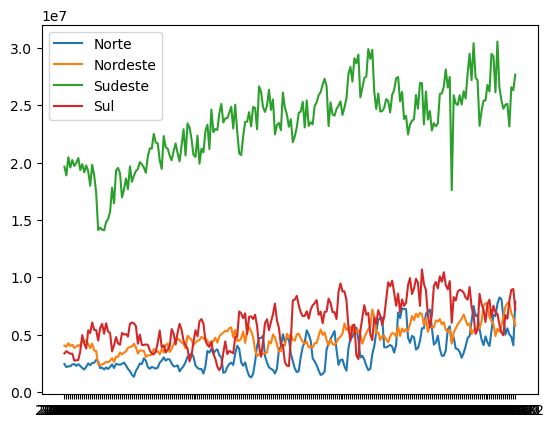

In [77]:
plt.plot(norte, label = "Norte")
plt.plot(nordeste, label = "Nordeste")
plt.plot(sudeste, label = "Sudeste")
plt.plot(sul, label = "Sul")
plt.legend(loc="upper left")